<a href="https://colab.research.google.com/github/SmritiReddyy/MLOps_OCR_Only/blob/main/Integrated1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# # ============================================================
# # CELL 1: INSTALL ALL DEPENDENCIES
# # ============================================================
# # %%capture

# !pip uninstall -y numpy paddlepaddle paddleocr torch transformers sentencepiece 2>/dev/null
# !pip install numpy==1.26.4
# !pip install -q pymupdf Pillow scipy
# !pip install -q pytesseract
# !apt-get install -qq tesseract-ocr tesseract-ocr-spa > /dev/null 2>&1
# !pip install paddlepaddle==2.6.2
# !pip install paddleocr==2.8.1
# !pip install torch==2.2.2
# !pip install transformers==4.38.2 sentencepiece
# !pip install langchain==0.0.352 langchain-community
# !pip install groq
# !pip install presidio-analyzer presidio-anonymizer
# !pip install sacrebleu
# !python -m spacy download en_core_web_lg -q

# print("\n" + "="*60)
# print("✅ All dependencies installed")
# print("="*60)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: paddlepaddle 2.6.2
Uninstalling paddlepaddle-2.6.2:
  Successfully uninstalled paddlepaddle-2.6.2
Found existing installation: paddleocr 2.8.1
Uninstalling paddleocr-2.8.1:
  Successfully uninstalled paddleocr-2.8.1
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
accelerate 1.12.0 requires torch>=2.0.0, which is not installed.
torchtune 0.6.1 requires sentencepiece, which is not installed.
peft 0.18.1 requires torch>=1.13.0, which is not installed.
peft 0.18.1 requires transformers, which is not installed.
sentence-transformers 5.

  Using cached paddlepaddle-2.6.2-cp312-cp312-manylinux1_x86_64.whl.metadata (8.6 kB)
Using cached paddlepaddle-2.6.2-cp312-cp312-manylinux1_x86_64.whl (125.9 MB)
  Using cached paddleocr-2.8.1-py3-none-any.whl.metadata (19 kB)
Using cached paddleocr-2.8.1-py3-none-any.whl (407 kB)
  Using cached torch-2.2.2-cp312-cp312-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.wh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.5 which is incompatible.
google-adk 1.25.0 requires tenacity<10.0.0,>=9.0.0, but you have tenacity 8.5.0 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0

In [1]:
# ============================================================
# CELL 2: IMPORTS & GLOBAL CONFIGURATION
# ============================================================
import os, re, json, time, tempfile
import numpy as np
import torch
import pymupdf
from PIL import Image, ImageDraw
from scipy.ndimage import sobel
from IPython.display import display, Image as IPImage
import pytesseract

os.environ["PADDLE_PDX_DISABLE_MODEL_SOURCE_CHECK"] = "True"

# PaddleOCR
PaddleOCR = None
try:
    from paddleocr import PaddleOCR
    print("✅ PaddleOCR: available")
except Exception as e:
    print(f"⚠️  PaddleOCR unavailable: {e} — will fall back to Tesseract")

# TrOCR for handwriting
trocr_processor = None
trocr_model = None
try:
    from transformers import TrOCRProcessor, VisionEncoderDecoderModel
    print("⏳ Loading TrOCR (handwriting)...")
    trocr_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
    trocr_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
    trocr_model.eval()
    if torch.cuda.is_available():
        trocr_model = trocr_model.to("cuda")
        print("✅ TrOCR: loaded (GPU)")
    else:
        print("✅ TrOCR: loaded (CPU — will be slow)")
except Exception as e:
    print(f"⚠️  TrOCR unavailable: {e} — handwritten pages will use Tesseract")

# Global constants
OCR_DPI              = 300
OCR_CONFIDENCE       = 0.50
WORK_DIR             = "/content/courtaccess_output"
os.makedirs(WORK_DIR, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Device: {device}")
print("✅ All imports ready")



✅ PaddleOCR: available
⏳ Loading TrOCR (handwriting)...


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ TrOCR: loaded (GPU)

✅ Device: cuda
✅ All imports ready


In [11]:

# ============================================================
# CELL 3: UPLOAD PDF
# ============================================================
from pathlib import Path
from google.colab import files

print("📤 Upload a PDF to translate:")
try:
    uploaded = files.upload()
    if uploaded:
        fname = list(uploaded.keys())[0]
        pdf_path = Path(WORK_DIR) / fname
        pdf_path.write_bytes(uploaded[fname])
        INPUT_PDF = str(pdf_path)
        print(f"✅ Uploaded: {INPUT_PDF}")
except KeyboardInterrupt:
    INPUT_PDF = None
    print("Upload skipped.")

assert INPUT_PDF and "courtaccess_translated" not in INPUT_PDF, \
    "❌ INPUT_PDF points to a previous output — re-upload your original PDF."



📤 Upload a PDF to translate:


Saving generated.pdf to generated.pdf
✅ Uploaded: /content/courtaccess_output/generated.pdf


In [12]:

# ============================================================
# CELL 4: FONT UTILITIES
# Maps PDF font names to PyMuPDF built-in codes.
# fit_fontsize() shrinks translated text to fit bounding boxes
# — critical because Spanish runs ~20-30% longer than English.
# ============================================================

FONT_MAP = {
    "Helvetica": "helv",           "Helvetica-Bold": "hebo",
    "Helvetica-Oblique": "heit",   "Helvetica-BoldOblique": "hebi",
    "Times-Roman": "tiro",         "Times-Bold": "tibo",
    "Times-Italic": "tiit",        "Times-BoldItalic": "tibi",
    "Courier": "cour",             "Courier-Bold": "cobo",
    "Courier-Oblique": "coit",     "Courier-BoldOblique": "cobi",
    "Symbol": "symb",              "ZapfDingbats": "zadb",
}

def get_font_code(span):
    fontname = span.get("font", "")
    flags    = span.get("flags", 0)
    direct   = FONT_MAP.get(fontname)
    if direct:
        return direct
    is_bold   = bool(flags & 16) or "bold"    in fontname.lower()
    is_italic = bool(flags & 2)  or "italic"  in fontname.lower() or "oblique" in fontname.lower()
    is_mono   = bool(flags & 8)  or "courier" in fontname.lower() or "mono"    in fontname.lower()
    is_serif  = bool(flags & 4)  or "times"   in fontname.lower() or "serif"   in fontname.lower() or "nimbus" in fontname.lower()
    if is_mono:
        return "cobi" if is_bold and is_italic else "cobo" if is_bold else "coit" if is_italic else "cour"
    elif is_serif:
        return "tibi" if is_bold and is_italic else "tibo" if is_bold else "tiit" if is_italic else "tiro"
    else:
        return "hebi" if is_bold and is_italic else "hebo" if is_bold else "heit" if is_italic else "helv"

def fit_fontsize(text, original_size, bbox_width, fontname="helv", min_size=4.0):
    font = pymupdf.Font(fontname)
    size = original_size
    while size >= min_size:
        if font.text_length(text, fontsize=size) <= bbox_width * 0.95:
            return size
        size -= 0.5
    return min_size

def estimate_fontsize(text, target_width, fontname="helv"):
    font = pymupdf.Font(fontname)
    best = 5.0
    for s10 in range(50, 260, 2):
        size = s10 / 10.0
        if font.text_length(text, fontsize=size) <= target_width:
            best = size
        else:
            break
    return best

def get_background_color(page, bbox):
    try:
        pix = page.get_pixmap(clip=pymupdf.Rect(bbox), matrix=pymupdf.Matrix(1, 1))
        s = pix.samples
        if len(s) >= 3:
            return (s[0]/255, s[1]/255, s[2]/255)
    except Exception:
        pass
    return (1, 1, 1)

print("✅ Font utilities ready")


✅ Font utilities ready


In [13]:
# ============================================================
# CELL 5: PAGE CLASSIFIER (with handwriting detection)
# DIGITAL     — has vector drawings (borders, boxes, lines)
# SCANNED     — image-based, no vector drawings
# OCR'd SCAN  — text spans + embedded image, no drawings
# HANDWRITTEN — detected via Sobel edge variance + baseline irregularity
# BLANK       — no text, no images
# ============================================================

def _handwriting_score(gray: np.ndarray) -> float:
    edges      = np.hypot(sobel(gray.astype(float), axis=1), sobel(gray.astype(float), axis=0))
    stroke_var = edges.std() / (edges.mean() + 1e-6)
    row_den    = np.mean(gray < 128, axis=1)
    active_r   = row_den[row_den > 0.01]
    base_irr   = (active_r.std() / (active_r.mean() + 1e-6)) if len(active_r) > 1 else 0.5
    col_den    = np.mean(gray < 128, axis=0)
    active_c   = col_den[col_den > 0.01]
    space_irr  = (active_c.std() / (active_c.mean() + 1e-6)) if len(active_c) > 1 else 0.5
    score = (
        0.35 * min(stroke_var / 2.0, 1.0) +
        0.35 * min(base_irr   / 1.5, 1.0) +
        0.30 * min(space_irr  / 1.5, 1.0)
    )
    return float(min(max(score, 0.0), 1.0))

def classify_page(page):
    td         = page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    span_count = 0
    img_blocks = 0
    for b in td["blocks"]:
        if b["type"] == 1:
            img_blocks += 1
        elif b["type"] == 0:
            for line in b["lines"]:
                for span in line["spans"]:
                    if span["text"].strip():
                        span_count += 1

    images    = page.get_images(full=True)
    drawings  = page.get_drawings()
    page_area = page.rect.width * page.rect.height
    total_img_area  = 0
    has_large_image = False

    for img in images:
        try:
            for r in page.get_image_rects(img[0]):
                total_img_area += r.width * r.height
        except Exception:
            pass
    if total_img_area == 0:
        for b in td["blocks"]:
            if b["type"] == 1:
                bb = b["bbox"]
                total_img_area += (bb[2]-bb[0]) * (bb[3]-bb[1])
    if total_img_area == 0 and images:
        for img in images:
            if img[2] > 1000 and img[3] > 1000:
                has_large_image = True
                total_img_area  = page_area * 0.9
                break

    img_coverage   = total_img_area / page_area if page_area > 0 else 0
    is_scanned     = False
    is_handwritten = False
    page_type      = "DIGITAL"

    if span_count == 0 and not images:
        page_type = "BLANK"
    elif span_count > 10 and len(drawings) > 5:
        page_type = "DIGITAL"
    elif span_count > 10 and len(drawings) < 5 and (img_coverage > 0.3 or has_large_image or images):
        is_scanned = True
        page_type  = "OCR'd SCAN"
    elif span_count > 10 and not images:
        page_type = "DIGITAL"
    elif img_coverage > 0.3 or has_large_image or (images and span_count < 10):
        is_scanned = True
        pix  = page.get_pixmap(dpi=200)
        gray = np.array(Image.frombytes("RGB", (pix.width, pix.height), pix.samples).convert("L"))
        if _handwriting_score(gray) > 0.6:
            page_type      = "HANDWRITTEN"
            is_handwritten = True
        else:
            page_type = "SCANNED"
    elif page.get_text().strip() and len(page.get_text().strip()) > 50:
        page_type = "DIGITAL"
    else:
        is_scanned = True
        page_type  = "SCANNED"

    return {
        "page_type":       page_type,
        "is_scanned":      is_scanned,
        "is_handwritten":  is_handwritten,
        "span_count":      span_count,
        "images":          len(images),
        "img_blocks":      img_blocks,
        "drawings":        len(drawings),
        "img_coverage":    round(img_coverage * 100, 1),
        "has_large_image": has_large_image,
    }

def is_content_image(info):
    return info["img_coverage"] > 80 and info["span_count"] < 5

print("✅ Page classifier ready")



✅ Page classifier ready


In [14]:
# ============================================================
# CELL 6: NLLB-200 1.3B TRANSLATION SETUP
# Loads facebook/nllb-200-distilled-1.3B for English → Spanish.
# should_translate() skips numbers, citations, URLs, dates, etc.
# Hallucination guard rejects outputs with abnormal length ratios.
# ============================================================
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_NAME  = "facebook/nllb-200-distilled-1.3B"
SOURCE_LANG = "eng_Latn"
TARGET_LANG = "spa_Latn"

print("⏳ Loading NLLB-200 1.3B...")
nllb_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
nllb_model     = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)
nllb_model.eval()
print("✅ NLLB-200 1.3B ready")

SKIP_PATTERNS = [
    r"^[\d\s\.\-\/\(\)\\,]+$",
    r"^\s*[xX]\s*$",
    r"^https?://",
    r"^\$[\d,\.]+$",
    r"^[\d]{1,2}[\/\-][\d]{1,2}[\/\-][\d]{2,4}$",
    r"^[\-\s]*$",
    r"^\[[\d\.\(\)a-zA-Z\;\s]+\]",
    r"^\d+\.\s*$",
    r"^[_#\s]+$",
    r"^Mass\.\s+R\.",
    r"^\d+:\d+-[a-zA-Z]+-\d+",
]

def should_translate(text: str) -> bool:
    t = text.strip()
    if not t or len(t) <= 3:
        return False
    if t.isupper() and len(t) < 12:
        return False
    return not any(re.match(p, t) for p in SKIP_PATTERNS)

def split_into_sentences(text: str) -> list:
    return [p for p in re.split(r"(?<=[.!?])\s+", text.strip()) if p.strip()]

def _raw_batch_translate(texts: list) -> list:
    nllb_tokenizer.src_lang = SOURCE_LANG
    enc = nllb_tokenizer(
        texts, return_tensors="pt", padding=True,
        truncation=True, max_length=512
    ).to(device)
    gen = nllb_model.generate(
        **enc,
        forced_bos_token_id=nllb_tokenizer.convert_tokens_to_ids(TARGET_LANG),
        max_length=min(512, enc["input_ids"].shape[1] + 40),
        num_beams=4,
        early_stopping=True,
    )
    return nllb_tokenizer.batch_decode(gen, skip_special_tokens=True)

def batch_translate(texts: list) -> list:
    results = []
    for text in texts:
        if not should_translate(text):
            results.append(text)
            continue
        sentences  = split_into_sentences(text)
        translated = _raw_batch_translate([text])[0] if len(sentences) <= 1 \
                     else " ".join(_raw_batch_translate(sentences))
        ratio = len(translated) / max(len(text), 1)
        if ratio > 2.8 or ratio < 0.15:
            print(f"   ⚠️  Hallucination (ratio={ratio:.1f}), keeping original: '{text[:60]}'")
            results.append(text)
        else:
            results.append(translated)
    return results

print("✅ Translation functions ready")


⏳ Loading NLLB-200 1.3B...
✅ NLLB-200 1.3B ready
✅ Translation functions ready


In [15]:
# ============================================================
# CELL 7: GROQ LLaMA 3.3 70B LEGAL VERIFICATION
# High-risk spans (legal citations, terms, section references)
# are batched and sent to Groq for accuracy review.
# Rate-limited to 25 requests/minute (Groq free tier).
# ============================================================
from groq import Groq
from google.colab import userdata

groq_client         = Groq(api_key=userdata.get("GROQ_API_KEY"))
_groq_request_times = []

def _wait_for_rate_limit(max_per_minute=25):
    global _groq_request_times
    now = time.time()
    _groq_request_times = [t for t in _groq_request_times if now - t < 60]
    if len(_groq_request_times) >= max_per_minute:
        wait = 60 - (now - _groq_request_times[0]) + 1
        print(f"   ⏳ Groq rate limit — waiting {wait:.1f}s...")
        time.sleep(wait)
    _groq_request_times.append(time.time())

def _strip_fences(text: str) -> str:
    text = text.strip()
    for prefix in ("```json", "```"):
        if text.startswith(prefix):
            text = text[len(prefix):]
    if text.endswith("```"):
        text = text[:-3]
    return text.strip()

HIGH_RISK_PATTERNS = [
    r"Mass\.\s+R\.",        r"\[[\d\.\(\)a-zA-Z\;\s]+\]",
    r"\bCommonwealth\b",    r"\bwaiver\b|\bwaive\b",
    r"\bdefendant\b|\bplaintiff\b", r"\bdocket\b",
    r"G\.L\.\s+c\.",        r"Paragraph\s+\d+",
    r"§\s*\d+",             r"^\d+\.",
    r"\breciprocal\b",      r"\bautomatic\b",
    r"\bARRAIGNMENT\b",     r"\bplea\b|\bplead\b",
]

def is_high_risk(text: str) -> bool:
    return any(re.search(p, text, re.IGNORECASE) for p in HIGH_RISK_PATTERNS)

def verify_page_translations(original_spans: list, translated_spans: list, batch_size=8) -> list:
    verified = list(translated_spans)
    hi_risk  = [i for i, o in enumerate(original_spans) if should_translate(o) and is_high_risk(o)]
    if not hi_risk:
        print("   ✅ No high-risk spans — skipping Groq")
        return verified
    print(f"   🔍 {len(hi_risk)}/{len(original_spans)} spans flagged as high-risk")
    for start in range(0, len(hi_risk), batch_size):
        batch_idx   = hi_risk[start:start + batch_size]
        orig_batch  = [original_spans[i]   for i in batch_idx]
        trans_batch = [translated_spans[i] for i in batch_idx]
        _wait_for_rate_limit()
        pairs = "\n".join(
            f"{k+1}. EN: {o}\n   ES: {t}"
            for k, (o, t) in enumerate(zip(orig_batch, trans_batch))
        )
        prompt = (
            "You are a legal translator verifying English to Spanish translations "
            "of Massachusetts court documents. For each pair, check if the Spanish "
            "is legally accurate. Pay special attention to: legal citations (Mass. R. Crim. P.), "
            "legal terms (Commonwealth, defendant, waiver, docket), "
            "section references (G.L. c. X, § Y), and paragraph numbers.\n\n"
            "Return ONLY a JSON array of corrected Spanish strings, one per pair, "
            "in the same order. If already correct, return unchanged. "
            "No explanation, no markdown, just the JSON array.\n\n"
            f"PAIRS:\n{pairs}\n\n"
            'Return format: ["corrected span 1", "corrected span 2", ...]'
        )
        try:
            resp = groq_client.chat.completions.create(
                model="llama-3.3-70b-versatile",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=1024,
            )
            corrected = json.loads(_strip_fences(resp.choices[0].message.content))
            if isinstance(corrected, list) and len(corrected) == len(batch_idx):
                for idx, c in zip(batch_idx, corrected):
                    if c and c.strip():
                        ratio = len(c) / max(len(translated_spans[idx]), 1)
                        if 0.2 <= ratio <= 4.0:
                            verified[idx] = c.strip()
                print(f"   ✅ Batch {start//batch_size + 1}: verified {len(batch_idx)} spans")
            else:
                print(f"   ⚠️  Batch {start//batch_size + 1}: length mismatch, keeping NLLB output")
        except Exception as e:
            print(f"   ⚠️  Groq error: {e} — keeping NLLB output")
    return verified

# Connection test
print("🧪 Testing Groq connection...")
_wait_for_rate_limit()
_test = groq_client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=[{"role": "user", "content": "Reply with just: OK"}],
    max_tokens=5,
)
print(f"   Response: {_test.choices[0].message.content.strip()}")
print("✅ Groq LLaMA 3.3 70B ready")



🧪 Testing Groq connection...
   Response: OK
✅ Groq LLaMA 3.3 70B ready


In [16]:
# ============================================================
# CELL 8: PRESIDIO PII REDACTION
# Detects and redacts PII in text spans and PDF form widgets.
# Legal citations and section references are always preserved.
# Set REDACT_PII = False for personal-use translation.
# ============================================================
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig

print("⏳ Loading Presidio...")
analyzer   = AnalyzerEngine()
anonymizer = AnonymizerEngine()
print("✅ Presidio ready")

REDACT_PII   = True   # set False for personal use
REDACT_DATES = False  # keep dates visible in output

PII_ENTITIES = [
    "PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS", "US_SSN",
    "CREDIT_CARD", "US_PASSPORT", "US_DRIVER_LICENSE",
    "IP_ADDRESS", "DATE_TIME",
]
if not REDACT_DATES and "DATE_TIME" in PII_ENTITIES:
    PII_ENTITIES.remove("DATE_TIME")

PRESERVE_PATTERNS = [
    r"G\.L\.\s+c\.\s+\d+",    r"§\s*\d+[A-Z]?",
    r"\[\d+[\.\(\)a-zA-Z\;]+\]", r"Mass\.\s+R\.\s+Crim\.",
    r"Paragraph\s+\d+",         r"TC\d+",
    r"P\.\s*\d+\.\d+",
]

def _should_preserve(text: str) -> bool:
    return any(re.search(p, text, re.IGNORECASE) for p in PRESERVE_PATTERNS)

def redact_pii(text: str) -> tuple:
    if not REDACT_PII or not text.strip() or _should_preserve(text):
        return text, []
    try:
        results = analyzer.analyze(text=text, entities=PII_ENTITIES, language="en")
    except Exception:
        return text, []
    if not results:
        return text, []
    found = list(set(r.entity_type for r in results))
    anon  = anonymizer.anonymize(
        text=text, analyzer_results=results,
        operators={e: OperatorConfig("replace", {"new_value": f"[{e}]"}) for e in found}
    )
    return anon.text, found

def redact_spans(original_texts: list, translated_texts: list) -> list:
    if not REDACT_PII:
        return translated_texts
    redacted = list(translated_texts)
    total    = 0
    for i, (orig, trans) in enumerate(zip(original_texts, translated_texts)):
        _, entities = redact_pii(orig)
        if not entities:
            continue
        redacted[i], _ = redact_pii(trans)
        total += 1
    if total == 0:
        print(f"   ✅ No PII found in {len(original_texts)} spans")
    else:
        print(f"   🔒 Redacted PII in {total}/{len(original_texts)} spans")
    return redacted

def redact_form_fields(page) -> int:
    if not REDACT_PII:
        return 0
    count = 0
    for w in list(page.widgets()):
        val = str(w.field_value or "").strip()
        if not val:
            continue
        redacted, entities = redact_pii(val)
        if entities:
            w.field_value = redacted
            w.update()
            if w.rect:
                page.add_redact_annot(w.rect, fill=(1, 1, 1))
            count += 1
    if count > 0:
        page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)
    return count

print("✅ PII redaction ready")



⏳ Loading Presidio...


✅ Presidio ready
✅ PII redaction ready


In [17]:
# ============================================================
# CELL 9: RECONSTRUCTION FUNCTIONS
# Four paths depending on page type:
#   reconstruct_digital_page()           — span-level translate & reinsert
#   reconstruct_scanned_page_paddle()    — PaddleOCR → translate → reinsert
#   reconstruct_scanned_page_tesseract() — Tesseract fallback path
#   reconstruct_handwritten_page()       — TrOCR/Tesseract → translate → reinsert
# All paths: NLLB translate → Groq verify → PII redact → reinsert.
# Signature regions on scanned pages are detected and preserved.
# ============================================================

def _is_signature_region(text, conf, bbox_height, all_detections, det_index):
    if "signature" in text.lower().strip():
        return False
    for other in all_detections:
        if "signature" in other[1][0].lower():
            other_ys = [p[1] for p in other[0]]
            this_ys  = [p[1] for p in all_detections[det_index][0]]
            if abs(min(this_ys) - max(other_ys)) < 150 and len(text) < 20 and conf < 0.92:
                return True
    return len(text) < 15 and conf < 0.90 and bbox_height > 70


def reconstruct_digital_page(out_page, use_verification=True):
    td = out_page.get_text("dict", flags=pymupdf.TEXTFLAGS_TEXT)
    all_spans = [
        span
        for block in td["blocks"] if block["type"] == 0
        for line  in block["lines"]
        for span  in line["spans"]
        if span["text"].strip()
    ]
    if not all_spans:
        fc = redact_form_fields(out_page)
        if fc:
            print(f"   🔒 Redacted {fc} form field(s)")
        return 0

    original_texts   = [s["text"] for s in all_spans]
    translated_texts = batch_translate(original_texts)

    if use_verification:
        print(f"   🔍 Running Groq verification on {len(all_spans)} spans...")
        trans_idx = [i for i, t in enumerate(original_texts) if should_translate(t)]
        if trans_idx:
            orig_v   = [original_texts[i]   for i in trans_idx]
            trans_v  = [translated_texts[i] for i in trans_idx]
            verified = verify_page_translations(orig_v, trans_v, batch_size=8)
            for idx, vt in zip(trans_idx, verified):
                translated_texts[idx] = vt

    print("   🔒 Running PII redaction...")
    translated_texts = redact_spans(original_texts, translated_texts)
    fc = redact_form_fields(out_page)
    if fc:
        print(f"   🔒 Redacted {fc} form field(s)")

    for span in all_spans:
        bg = get_background_color(out_page, span["bbox"])
        out_page.add_redact_annot(pymupdf.Rect(span["bbox"]), fill=bg)
    out_page.apply_redactions(images=pymupdf.PDF_REDACT_IMAGE_NONE)

    count = 0
    for span, text in zip(all_spans, translated_texts):
        if not text.strip():
            continue
        bbox   = pymupdf.Rect(span["bbox"])
        color  = pymupdf.sRGB_to_rgb(span["color"])
        fnt    = get_font_code(span)
        fitted = fit_fontsize(text, span["size"], bbox.width, fnt)
        origin = pymupdf.Point(span["origin"])
        if fitted < span["size"] * 0.6:
            origin = pymupdf.Point(bbox.x0, bbox.y0 + bbox.height * 0.78)
        try:
            out_page.insert_text(origin, text, fontsize=fitted, fontname=fnt, color=color)
            count += 1
        except Exception:
            try:
                out_page.insert_text(origin, text, fontsize=fitted, fontname="helv", color=color)
                count += 1
            except Exception:
                pass
    return count


def reconstruct_scanned_page_paddle(out_page, ocr_engine):
    zoom = OCR_DPI / 72
    pix  = out_page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    tmp  = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    tmp.write(pix.tobytes("png"))
    tmp.close()
    result     = ocr_engine.ocr(tmp.name, cls=True)
    os.unlink(tmp.name)
    detections = result[0] if result and result[0] else []
    if not detections:
        return 0

    sx, sy  = out_page.rect.width / pix.width, out_page.rect.height / pix.height
    shape   = out_page.new_shape()
    regions = []
    skipped = 0

    for i, det in enumerate(detections):
        text, conf = det[1][0], det[1][1]
        if conf < OCR_CONFIDENCE or not text.strip():
            continue
        h_px = max(p[1] for p in det[0]) - min(p[1] for p in det[0])
        if _is_signature_region(text, conf, h_px, detections, i):
            skipped += 1
            continue
        xs   = [p[0] for p in det[0]]
        ys   = [p[1] for p in det[0]]
        rect = pymupdf.Rect(min(xs)*sx-1, min(ys)*sy-1, max(xs)*sx+1, max(ys)*sy+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))

    shape.commit(overlay=True)
    if skipped:
        print(f"      🖊️  Preserved {skipped} signature region(s)")
    if not regions:
        return 0

    original_texts   = [r["text"] for r in regions]
    translated_texts = batch_translate(original_texts)
    print(f"   🔍 Running Groq verification on {len(regions)} OCR spans...")
    translated_texts = verify_page_translations(original_texts, translated_texts, batch_size=8)
    print("   🔒 Running PII redaction...")
    translated_texts = redact_spans(original_texts, translated_texts)

    count = 0
    for r, text in zip(regions, translated_texts):
        if not text.strip():
            continue
        rect   = r["rect"]
        fitted = fit_fontsize(text, rect.height * 0.75, rect.width, "helv", min_size=4.0)
        fitted = max(4.0, min(fitted, rect.height * 0.9))
        origin = pymupdf.Point(rect.x0, rect.y0 + rect.height * 0.78)
        try:
            out_page.insert_text(origin, text, fontsize=fitted, fontname="helv", color=(0, 0, 0))
            count += 1
        except Exception:
            pass
    return count


def reconstruct_scanned_page_tesseract(out_page):
    zoom   = OCR_DPI / 72
    pix    = out_page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img    = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data   = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    sx, sy = out_page.rect.width / pix.width, out_page.rect.height / pix.height

    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        if int(data["conf"][i]) < 30 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"texts": [], "x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        ln["texts"].append(text)
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x);   ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x+w); ln["y1"] = max(ln["y1"], y+h)

    shape   = out_page.new_shape()
    regions = []
    for ln in lines.values():
        text = " ".join(ln["texts"])
        rect = pymupdf.Rect(ln["x0"]*sx-1, ln["y0"]*sy-1, ln["x1"]*sx+1, ln["y1"]*sy+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))
    shape.commit(overlay=True)

    original_texts   = [r["text"] for r in regions]
    translated_texts = batch_translate(original_texts)
    translated_texts = verify_page_translations(original_texts, translated_texts, batch_size=8)
    translated_texts = redact_spans(original_texts, translated_texts)

    count = 0
    for r, text in zip(regions, translated_texts):
        if not text.strip():
            continue
        rect   = r["rect"]
        fitted = fit_fontsize(text, rect.height * 0.75, rect.width, "helv", min_size=4.0)
        fitted = max(4.0, min(fitted, rect.height * 0.9))
        origin = pymupdf.Point(rect.x0, rect.y0 + rect.height * 0.78)
        try:
            out_page.insert_text(origin, text, fontsize=fitted, fontname="helv", color=(0, 0, 0))
            count += 1
        except Exception:
            pass
    return count


def reconstruct_handwritten_page(out_page):
    zoom   = OCR_DPI / 72
    pix    = out_page.get_pixmap(matrix=pymupdf.Matrix(zoom, zoom))
    img    = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)
    data   = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
    sx, sy = out_page.rect.width / pix.width, out_page.rect.height / pix.height
    pad    = 10

    lines = {}
    for i in range(len(data["text"])):
        text = data["text"][i].strip()
        if int(data["conf"][i]) < 10 or not text:
            continue
        key = (data["block_num"][i], data["line_num"][i])
        if key not in lines:
            lines[key] = {"x0": float("inf"), "y0": float("inf"), "x1": 0, "y1": 0}
        ln = lines[key]
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        ln["x0"] = min(ln["x0"], x);   ln["y0"] = min(ln["y0"], y)
        ln["x1"] = max(ln["x1"], x+w); ln["y1"] = max(ln["y1"], y+h)

    shape   = out_page.new_shape()
    regions = []
    for ln in lines.values():
        crop = img.crop((
            max(0, ln["x0"]-pad), max(0, ln["y0"]-pad),
            min(img.width, ln["x1"]+pad), min(img.height, ln["y1"]+pad)
        )).convert("RGB")
        if trocr_model is not None and trocr_processor is not None:
            try:
                dev = next(trocr_model.parameters()).device
                pv  = trocr_processor(images=crop, return_tensors="pt").pixel_values.to(dev)
                with torch.no_grad():
                    ids = trocr_model.generate(pv)
                text = trocr_processor.batch_decode(ids, skip_special_tokens=True)[0]
            except Exception:
                text = pytesseract.image_to_string(crop).strip()
        else:
            text = pytesseract.image_to_string(crop).strip()
        if not text.strip():
            continue
        rect = pymupdf.Rect(ln["x0"]*sx-1, ln["y0"]*sy-1, ln["x1"]*sx+1, ln["y1"]*sy+1)
        regions.append({"rect": rect, "text": text})
        shape.draw_rect(rect)
        shape.finish(color=None, fill=(1, 1, 1))

    shape.commit(overlay=True)
    if not regions:
        return 0

    original_texts   = [r["text"] for r in regions]
    translated_texts = batch_translate(original_texts)
    translated_texts = verify_page_translations(original_texts, translated_texts, batch_size=8)
    translated_texts = redact_spans(original_texts, translated_texts)

    count = 0
    for r, text in zip(regions, translated_texts):
        if not text.strip():
            continue
        rect   = r["rect"]
        fitted = fit_fontsize(text, rect.height * 0.75, rect.width, "helv", min_size=4.0)
        fitted = max(4.0, min(fitted, rect.height * 0.9))
        origin = pymupdf.Point(rect.x0, rect.y0 + rect.height * 0.78)
        try:
            out_page.insert_text(origin, text, fontsize=fitted, fontname="helv", color=(0, 0, 0))
            count += 1
        except Exception:
            pass
    return count

print("✅ Reconstruction functions ready (digital + scanned + handwritten)")



✅ Reconstruction functions ready (digital + scanned + handwritten)


In [18]:
# ============================================================
# CELL 10: MAIN PIPELINE LOOP
# Iterates every page, classifies it, routes to the correct
# reconstruction function, and saves the translated PDF.
# Also snapshots original English text for BLEU evaluation.
# ============================================================

# Snapshot original text before any modification (for BLEU)
original_texts_for_bleu = []
_snap = pymupdf.open(INPUT_PDF)
for pg in range(len(_snap)):
    original_texts_for_bleu.append(_snap[pg].get_text("text"))
_snap.close()

src_doc = pymupdf.open(INPUT_PDF)
out_doc = pymupdf.open()
out_doc.insert_pdf(src_doc)
src_doc.close()

paddle_engine     = None
digital_pages     = 0
scanned_pages     = 0
handwritten_pages = 0
blank_pages       = 0
skipped_pages     = 0

for pg in range(len(out_doc)):
    out_page = out_doc[pg]
    info     = classify_page(out_page)

    if info["page_type"] == "BLANK":
        print(f"\n⬜ Page {pg+1}/{len(out_doc)}: BLANK — skipping")
        blank_pages += 1

    elif info["page_type"] == "DIGITAL":
        print(f"\n📄 Page {pg+1}/{len(out_doc)}: DIGITAL "
              f"({info['span_count']} spans, {info['drawings']} drawings)")
        count = reconstruct_digital_page(out_page)
        print(f"   ✅ Translated & reinserted {count} spans")
        digital_pages += 1

    elif info["is_handwritten"]:
        engine_name = "TrOCR" if trocr_model is not None else "Tesseract"
        print(f"\n✍️  Page {pg+1}/{len(out_doc)}: HANDWRITTEN → {engine_name}")
        count = reconstruct_handwritten_page(out_page)
        print(f"   ✅ {engine_name}: translated {count} regions")
        handwritten_pages += 1

    elif info["is_scanned"]:
        if is_content_image(info):
            print(f"\n🖼️  Page {pg+1}/{len(out_doc)}: IMAGE-ONLY — preserving as-is")
            skipped_pages += 1
            continue
        print(f"\n📷 Page {pg+1}/{len(out_doc)}: {info['page_type']} "
              f"({info['span_count']} spans, {info['images']} images)")
        if PaddleOCR is not None:
            if paddle_engine is None:
                print("   ⏳ Initializing PaddleOCR...")
                paddle_engine = PaddleOCR(use_textline_orientation=True, lang="en")
            count = reconstruct_scanned_page_paddle(out_page, paddle_engine)
            print(f"   ✅ PaddleOCR: translated {count} regions")
        else:
            count = reconstruct_scanned_page_tesseract(out_page)
            print(f"   ✅ Tesseract: translated {count} regions")
        scanned_pages += 1

OUTPUT_PDF = os.path.join(WORK_DIR, "courtaccess_translated.pdf")
out_doc.save(OUTPUT_PDF)
out_doc.close()

print(f"\n{'='*60}")
print("🎉 PIPELINE COMPLETE")
print(f"   Digital pages:      {digital_pages}")
print(f"   Scanned pages:      {scanned_pages}")
print(f"   Handwritten pages:  {handwritten_pages}")
print(f"   Blank pages:        {blank_pages}")
print(f"   Image-only skipped: {skipped_pages}")
print(f"   Output: {OUTPUT_PDF}")
print(f"{'='*60}")



✍️  Page 1/1: HANDWRITTEN → TrOCR
   🔍 1/13 spans flagged as high-risk
   ✅ Batch 1: verified 1 spans
   ✅ No PII found in 13 spans
   ✅ TrOCR: translated 13 regions

🎉 PIPELINE COMPLETE
   Digital pages:      0
   Scanned pages:      0
   Handwritten pages:  1
   Blank pages:        0
   Image-only skipped: 0
   Output: /content/courtaccess_output/courtaccess_translated.pdf


📊 Computing BLEU scores...
   Page 1: skipped (empty text)
⚠️  No pages had extractable text for BLEU scoring.
🖼️  Page 1 — Original vs Translated:


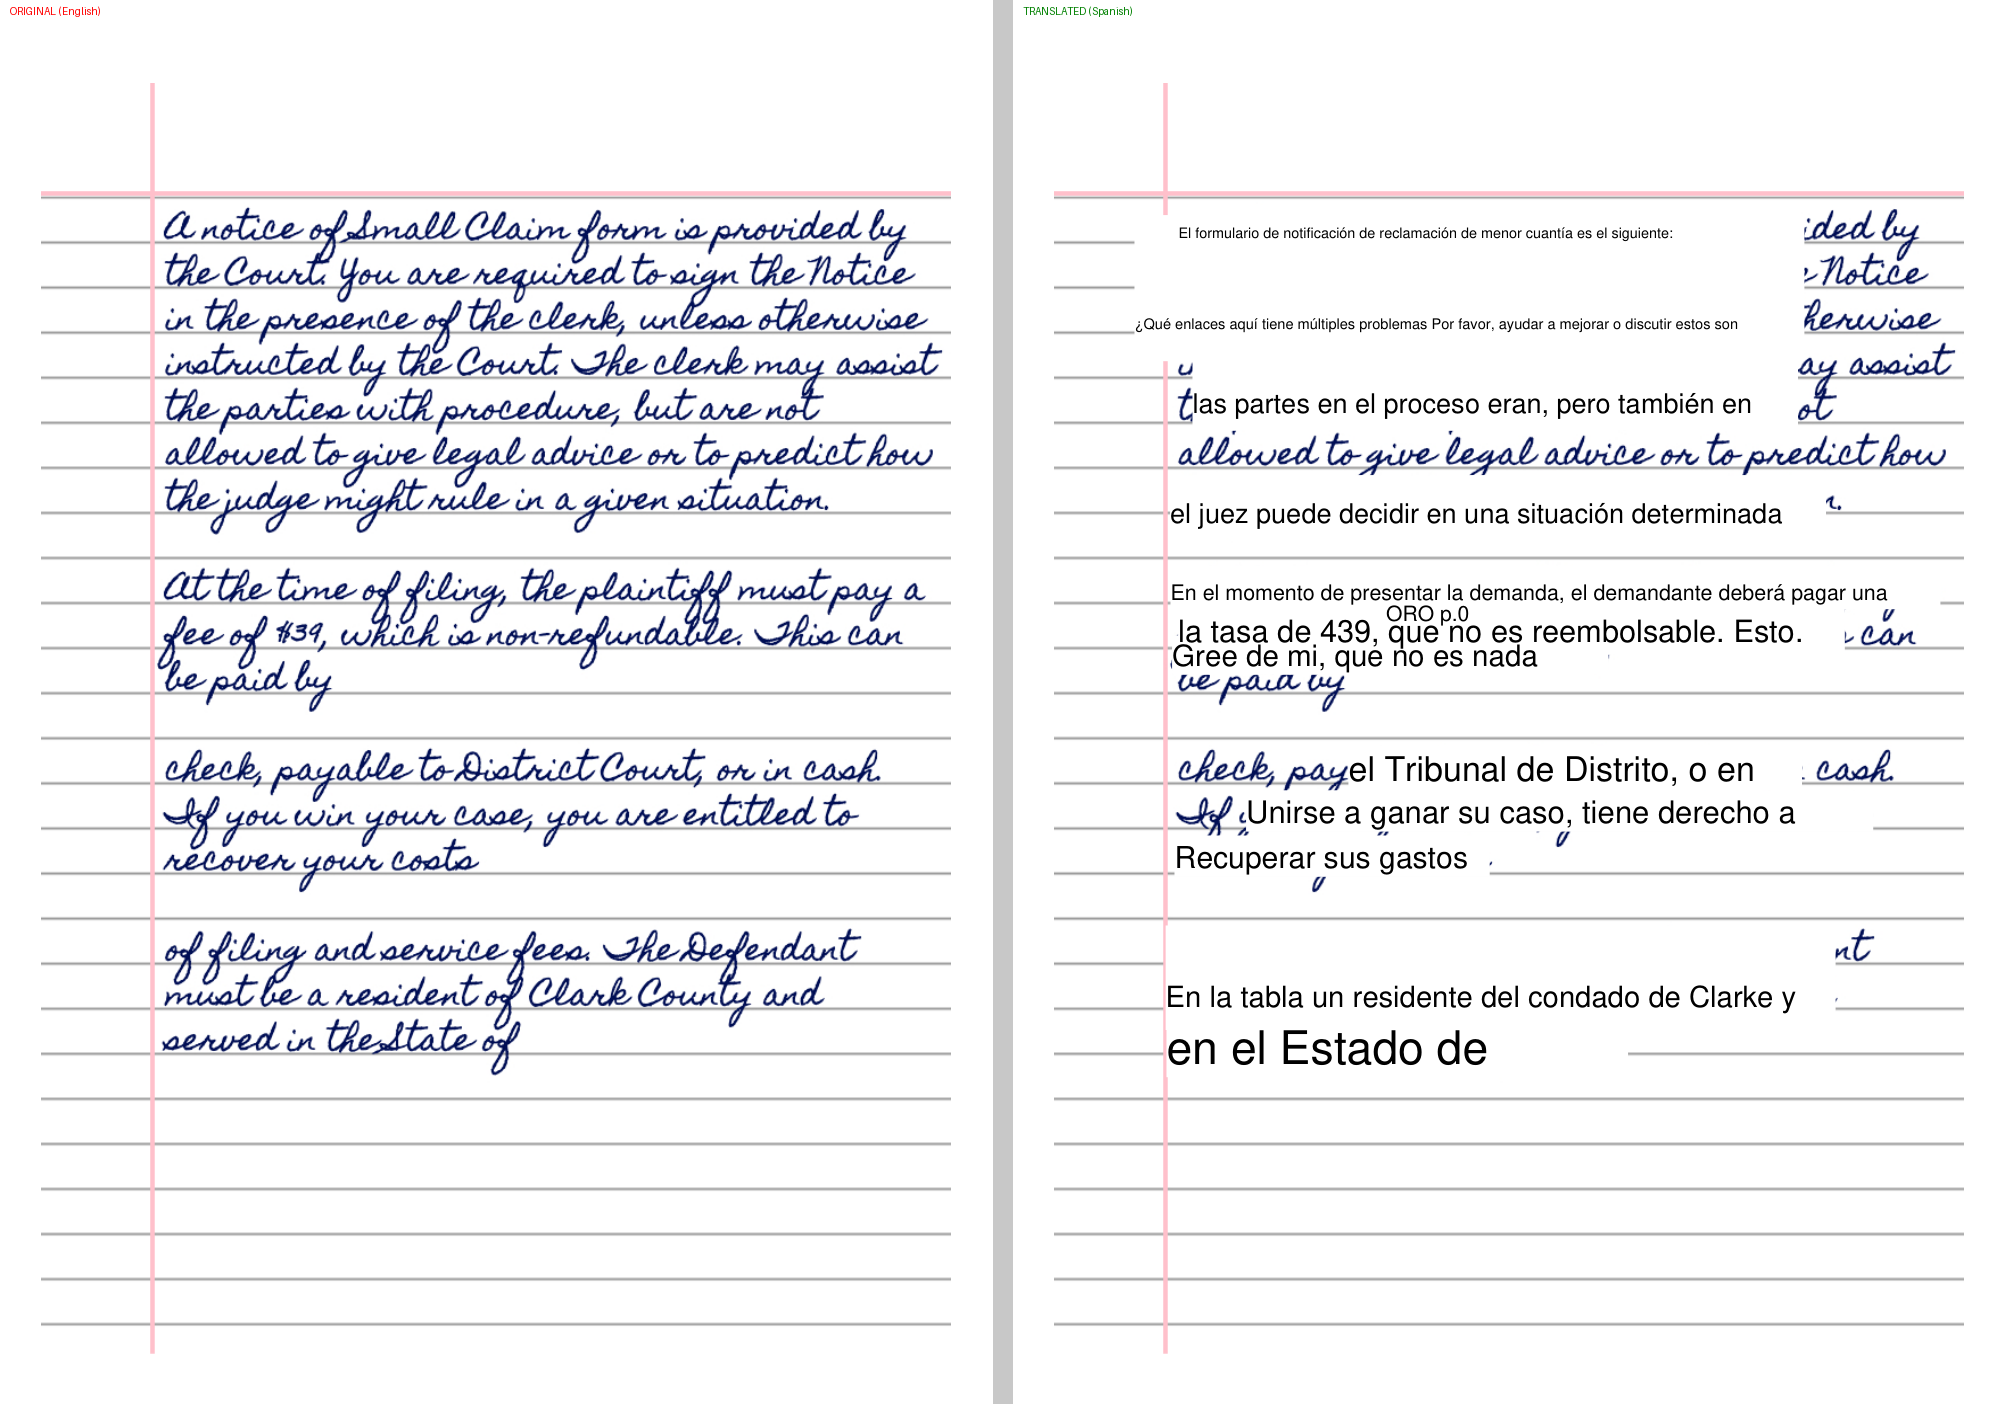

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: courtaccess_translated.pdf


In [19]:
# ============================================================
# CELL 11: BLEU SCORE EVALUATION
# Back-translates each page (Spanish → English via NLLB) and
# scores against the original English using sacrebleu.
# Reports per-page and corpus-level BLEU scores.
# ============================================================
import sacrebleu as sb

print("📊 Computing BLEU scores...")

trans_doc      = pymupdf.open(OUTPUT_PDF)
all_originals  = []
all_back_trans = []

for pg in range(len(trans_doc)):
    trans_text = trans_doc[pg].get_text("text").strip()
    orig_text  = original_texts_for_bleu[pg].strip()
    if not trans_text or not orig_text:
        print(f"   Page {pg+1}: skipped (empty text)")
        continue

    nllb_tokenizer.src_lang = TARGET_LANG
    enc = nllb_tokenizer(
        trans_text, return_tensors="pt", truncation=True, max_length=512
    ).to(device)
    gen = nllb_model.generate(
        **enc,
        forced_bos_token_id=nllb_tokenizer.convert_tokens_to_ids(SOURCE_LANG),
        max_length=512, num_beams=4, early_stopping=True,
    )
    back = nllb_tokenizer.batch_decode(gen, skip_special_tokens=True)[0]

    bleu = sb.corpus_bleu([back], [[orig_text]]).score
    all_originals.append(orig_text)
    all_back_trans.append(back)
    print(f"   Page {pg+1}: BLEU = {bleu:.2f}")

trans_doc.close()

if all_originals:
    corpus_bleu = sb.corpus_bleu(all_back_trans, [all_originals]).score
    print(f"\n{'='*60}")
    print(f"📊 CORPUS BLEU SCORE: {corpus_bleu:.2f}")
    print("   (back-translation round-trip; ~25–40 is typical for legal text)")
    print(f"{'='*60}")
else:
    print("⚠️  No pages had extractable text for BLEU scoring.")


# ============================================================
# CELL 12: VISUAL COMPARISON & DOWNLOAD
# Renders page 1 of original vs translated side-by-side for a
# quick visual sanity check, then downloads the output PDF.
# ============================================================

def show_comparison(original_path, translated_path, page_num=0, dpi=120):
    zoom = dpi / 72
    mat  = pymupdf.Matrix(zoom, zoom)
    orig_doc  = pymupdf.open(original_path)
    trans_doc = pymupdf.open(translated_path)
    pg        = min(page_num, len(orig_doc)-1, len(trans_doc)-1)

    orig_pix  = orig_doc[pg].get_pixmap(matrix=mat)
    trans_pix = trans_doc[pg].get_pixmap(matrix=mat)
    orig_img  = Image.frombytes("RGB", (orig_pix.width,  orig_pix.height),  orig_pix.samples)
    trans_img = Image.frombytes("RGB", (trans_pix.width, trans_pix.height), trans_pix.samples)

    max_h  = max(orig_img.height, trans_img.height)
    canvas = Image.new("RGB", (orig_img.width + trans_img.width + 20, max_h), (200, 200, 200))
    canvas.paste(orig_img,  (0, 0))
    canvas.paste(trans_img, (orig_img.width + 20, 0))

    draw = ImageDraw.Draw(canvas)
    draw.text((10, 5),                      "ORIGINAL (English)",   fill=(255, 0, 0))
    draw.text((orig_img.width + 30, 5),     "TRANSLATED (Spanish)", fill=(0, 128, 0))

    out_path = os.path.join(WORK_DIR, "comparison.png")
    canvas.save(out_path)
    display(IPImage(out_path))
    orig_doc.close()
    trans_doc.close()

print("🖼️  Page 1 — Original vs Translated:")
show_comparison(INPUT_PDF, OUTPUT_PDF, page_num=0)

files.download(OUTPUT_PDF)
print("✅ Downloaded: courtaccess_translated.pdf")